# Imports

In [1]:
!pip install torchtext

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np

SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)

Mounted at /content/drive


# Data Processing

In [3]:
data = pd.read_csv("/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/emot140.csv")
data = data.drop('Unnamed: 0', axis = 1)
data.head()

,emote,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

texties = []
labels = []
dictionary = {}
size = 0

num_zeros = 0
num_fours = 0
lim = 75000

def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    # 1. tokenize
    tokens = nltk.word_tokenize(text)
    # 2. check if stopword
    tokens = [w.lower() for w in tokens if not w in stopwords.words("english")]
    return tokens

for index, row in data.iterrows():
  # checking if we can append to the end of the list
  coolio = False
  if (num_zeros == lim and num_fours == lim):
    break
  if ((row['emote'] == 0 and num_zeros < lim) or (row['emote'] == 4 and num_fours < lim)):
    coolio = True
  if not coolio:
    continue
  # processing the thing
  texts = preprocess_text(row['text'])
  words = []
  for i in range(len(texts)):
    if texts[i] in dictionary:
      words.append(dictionary[texts[i]])
    else:
      size += 1
      dictionary[texts[i]] = size
      words.append(size)
  if len(words) == 0:
    continue

  # updating the counts
  num_zeros += (row['emote'] == 0)
  num_fours += (row['emote'] == 4)

  # appends
  texties.append(torch.tensor(words, dtype = torch.int32))
  labels.append(torch.tensor([row['emote']], dtype = torch.int32))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


@jeolpeter thats an interesting blog about follow fail i enjoyed it thx for the share 


In [ ]:
text = torch.nn.utils.rnn.pad_sequence(texties, batch_first = True)
label = torch.stack(labels)
tdset = torch.utils.data.TensorDataset(text, label)

Save the Dataset!

In [ ]:
torch.save(tdset, "/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/sent_texts.pt")

In [ ]:
MXLEN = 0
for i in range(2 * lim):
  MXLEN = max(MXLEN, texties[i].size(0))
print(MXLEN)

36


# Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTM_Classifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
    super(LSTM_Classifier, self).__init__()
    # Embedding layer converts integer sequences to vector sequences
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    # LSTM layer process the vector sequences
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout, batch_first = True)
    #                     input           output                             bisexual?                      dropout_prob      whether or not batch_size comes first in the tensor.size()
    # Dense layer to predict
    self.fc = nn.Linear(hidden_dim * 2, output_dim)
    # Prediction activation function
    self.sigmoid = nn.Sigmoid()

  def forward(self, text, text_lengths):
    embedded = self.embedding(text) # embedded version
    # Thanks to packing, LSTM don't see padding tokens
    # and this makes our model better
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted = False)
    packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
    # Concatenating the final forward and backward hidden states
    hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
    dense_outputs = self.fc(hidden)
    #Final activation function
    outputs = self.sigmoid(dense_outputs)
    return outputs


# Dataloaders

Optional: load 'tdset' from the path

In [ ]:
tdset = torch.load('/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/sent_texts.pt')

Define the DataLoaders

In [ ]:
from torch.utils.data import DataLoader
print(len(tdset))
train_len = (int)(0.900 * len(tdset))
train_dataset, test_dataset = torch.utils.data.random_split(tdset, [train_len, len(tdset) - train_len])
print(train_len, len(tdset) - train_len)

b_size = 5

train_loader = DataLoader(train_dataset, batch_size = b_size, shuffle = True, pin_memory = True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = b_size, shuffle = False, pin_memory = True, num_workers = 2)

150000
135000 15000


# Training Loop

In [ ]:
torch.manual_seed(42)

model = LSTM_Classifier(vocab_size = len(dictionary) + 1,
                        embedding_dim = 100,
                        hidden_dim = 64,
                        output_dim = 5,
                        n_layers = 5,
                        bidirectional = True,
                        dropout = 0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
loss_fn = nn.BCELoss().to(device)
epochs = 12

tl = []

for i in range(epochs):
  model.train()
  train_loss = 0.00
  correct = 0.00
  total = 0.00
  for tweet, emotion in train_loader:
    tweet = tweet.cuda()
    emotion = emotion.cuda()
    text_lengths = []
    for j in range(b_size):
      goddamn = False
      for k in range(MXLEN):
        if tweet[j][k] == 0:
          text_lengths.append(k)
          goddamn = True
          break
      if goddamn == False:
        text_lengths.append(MXLEN)
    emotion_ = torch.nn.functional.one_hot(emotion.to(torch.int64), 5).to(torch.float)
    emotion_ = emotion_.squeeze(1)
    optimizer.zero_grad()
    y_pred = model(tweet, text_lengths)
    loss = loss_fn(y_pred, emotion_)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()/len(train_loader)
    prediction = y_pred.argmax(dim=1)
    emotion = emotion.squeeze(1)
    correct += prediction.eq(emotion).sum().item()
    total += emotion.size(0)
  tl.append(train_loss)
  print(correct, total)
  print(f"Epoch: {i+1}/{epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {correct/total:.4f}")

84664.0 135000.0
Epoch: 1/12, Training Loss: 0.2489, Training Accuracy: 0.6271
100927.0 135000.0
Epoch: 2/12, Training Loss: 0.2038, Training Accuracy: 0.7476
104488.0 135000.0
Epoch: 3/12, Training Loss: 0.1896, Training Accuracy: 0.7740
106644.0 135000.0
Epoch: 4/12, Training Loss: 0.1793, Training Accuracy: 0.7900
108552.0 135000.0
Epoch: 5/12, Training Loss: 0.1703, Training Accuracy: 0.8041
110260.0 135000.0
Epoch: 6/12, Training Loss: 0.1615, Training Accuracy: 0.8167
112299.0 135000.0
Epoch: 7/12, Training Loss: 0.1524, Training Accuracy: 0.8318
113782.0 135000.0
Epoch: 8/12, Training Loss: 0.1438, Training Accuracy: 0.8428
115476.0 135000.0
Epoch: 9/12, Training Loss: 0.1351, Training Accuracy: 0.8554
116983.0 135000.0
Epoch: 10/12, Training Loss: 0.1261, Training Accuracy: 0.8665
118580.0 135000.0
Epoch: 11/12, Training Loss: 0.1174, Training Accuracy: 0.8784
120124.0 135000.0
Epoch: 12/12, Training Loss: 0.1087, Training Accuracy: 0.8898


# Validation Loop

In [ ]:
b_size = 1
data_loader = DataLoader(test_dataset, batch_size = b_size, shuffle = True, pin_memory = True, num_workers = 2)

tensor([[ 1332,  9085,  1787,   233,  6193,   700,   324,   391, 23641,  1076,
           408,   391,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]], device='cuda:0',
       dtype=torch.int32)
negative
negative
tensor([[234,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0]], device='cuda:0',
       dtype=torch.int32)
negative
negative
tensor([[81864,  1070,  3159,  4612,   590,   613,  4765, 17930,  2795,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]], device='cuda:0',
       dtype=torch.int32)
positive
positive
tensor([[57224,   447,   487

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (5).

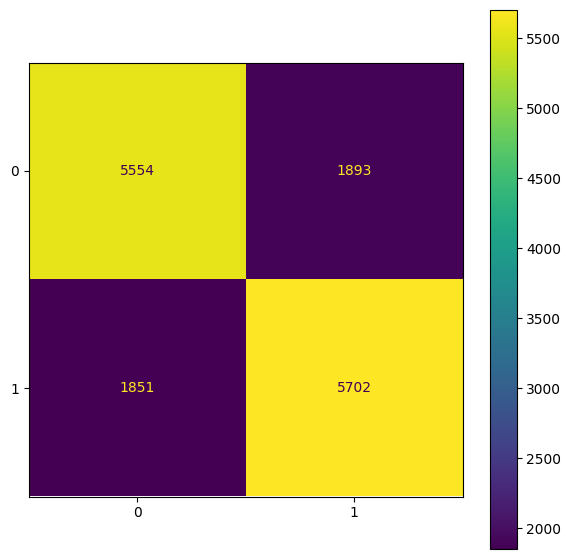

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

model.eval()
val_loss = 0.00
correct = 0.00
total = 0.00

mapping = ["negative", "", "", "", "positive"]

predicts = []
corrects = []
first_five = []

index = 0

for tweet, emotion in data_loader:
  tweet = tweet.cuda()
  emotion = emotion.cuda()
  text_lengths = []
  for j in range(b_size):
    goddamn = False
    for k in range(MXLEN):
      if tweet[j][k] == 0:
        text_lengths.append(k)
        goddamn = True
        break
    if goddamn == False:
      text_lengths.append(MXLEN)
  emotion_ = torch.nn.functional.one_hot(emotion.to(torch.int64), 5).to(torch.float)
  emotion_ = emotion_.squeeze(1)
  with torch.no_grad():
    y_pred = model(tweet, text_lengths)

  loss = loss_fn(y_pred, emotion_)
  val_loss += loss.item()/len(test_loader)
  emotion = emotion.squeeze(1)
  prediction = y_pred.argmax(dim=1)
  correct += prediction.eq(emotion).sum().item()
  total += emotion.size(0)

  predicts.append(prediction.item())
  corrects.append(emotion.item())

  if index < 5:
    print(tweet)
    first_five.append(tweet)
    print(mapping[prediction.item()])
    print(mapping[emotion.item()])

  index += 1

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {correct/total:.4f}")

confucian = metrics.confusion_matrix(corrects, predicts)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confucian, display_labels = mapping)
fig, ax = plt.subplots(figsize=(7,7))
cm_display.plot(ax = ax)
plt.show()

plt.plot(tl)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
dict2 = {

}

for key in dictionary:
  hash = dictionary[key]
  dict2[hash] = key

for i in range(5):
  tsr = first_five[i]
  tsr = tsr.squeeze(0)
  print(tsr.size())
  stri = ""
  for j in range(tsr.size(0)):
    word = tsr[j].item()
    if word == 0:
      break
    stri += dict2[word] + " "
  print(stri)

torch.Size([36])
at gatwick airport even flying made friends parking attendant tho pay parking 
torch.Size([36])
know 
torch.Size([36])
jeolpeter thats interesting blog follow fail enjoyed thx share 
torch.Size([36])
darrin working tonight 
torch.Size([36])
had great night tonight watching movie parents 


Save the Model!

In [ ]:
#torch.save(model, "/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/tmodel.pt")
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/drive/My Drive/Machine Learning/COSMOS/FINAL_PROJECT/DER/tmodel.pt') # Save